In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote_auto.csv')
print("df_under is the oversample data frame\n", data.rate.value_counts().sort_index())

df_under is the oversample data frame
 1    261
2    261
3    261
4    261
5    261
Name: rate, dtype: int64


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2475
RMSE: 0.7077
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2292
RMSE: 0.8200
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2461
RMSE: 0.8529
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2684
RMSE: 0.8171
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2225
RMSE: 0.8464
###############################################
The Results are: 

Average RMSE on Training Set: 0.24272929333801888
Average RMSE on Test Set: 0.8088178976444802
RMSE: 0.7891
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7890859271466404
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7891
MAE:  0.4657
MSE: 0.6227
Precision: 0.14
Recall: 0.12
the acc is 63.22


/tmp/ipykernel_5637/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2339
RMSE: 0.7590
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2397
RMSE: 0.7402
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2332
RMSE: 0.8069
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2517
RMSE: 0.7631
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2223
RMSE: 0.7975
###############################################
The Results are: 

Average RMSE on Training Set: 0.23617115368086394
Average RMSE on Test Set: 0.7733392055669611
RMSE: 0.7934
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7933797145453684
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7934
MAE:  0.4572
MSE: 0.6295
Precision: 0.15
Recall: 0.11
the acc is 64.75


/tmp/ipykernel_5637/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1820
RMSE: 0.8500
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2071
RMSE: 0.7221
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1526
RMSE: 0.9374
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1999
RMSE: 0.7441
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1961
RMSE: 0.7255
###############################################
The Results are: 

Average RMSE on Training Set: 0.18754516214979927
Average RMSE on Test Set: 0.7958187105217707
RMSE: 0.8579
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8578532323339204
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8579
MAE:  0.4983
MSE: 0.7359
Precision: 0.17
Recall: 0.12
the acc is 61.30


/tmp/ipykernel_5637/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1904
RMSE: 0.7960
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1907
RMSE: 0.7695
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1860
RMSE: 0.7854
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1899
RMSE: 0.7874
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2075
RMSE: 0.8463
###############################################
The Results are: 

Average RMSE on Training Set: 0.19288486410794842
Average RMSE on Test Set: 0.7969372841601347
RMSE: 0.7737
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7736589488324866
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7737
MAE:  0.4242
MSE: 0.5985
Precision: 0.23
Recall: 0.16
the acc is 68.58


/tmp/ipykernel_5637/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1278
RMSE: 0.7975
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1398
RMSE: 0.7282
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1115
RMSE: 0.8095
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1349
RMSE: 0.6878
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0766
RMSE: 0.8880
###############################################
The Results are: 

Average RMSE on Training Set: 0.11811720313713436
Average RMSE on Test Set: 0.7822011443158651
RMSE: 0.7099
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7098624156666445
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.7099
MAE:  0.3845
MSE: 0.5039
Precision: 0.21
Recall: 0.17
the acc is 69.35


/tmp/ipykernel_5637/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0884
RMSE: 0.7777
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0897
RMSE: 0.6365
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1011
RMSE: 0.8797
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0785
RMSE: 0.7450
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0898
RMSE: 0.7468
###############################################
The Results are: 

Average RMSE on Training Set: 0.08949877747552638
Average RMSE on Test Set: 0.7571395188439272
RMSE: 0.8858
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8857893016785426
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8858
MAE:  0.4833
MSE: 0.7846
Precision: 0.15
Recall: 0.13
the acc is 66.28


/tmp/ipykernel_5637/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1158
RMSE: 0.8070
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1228
RMSE: 0.8055
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1484
RMSE: 0.7316
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1260
RMSE: 0.8236
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1472
RMSE: 0.8155
###############################################
The Results are: 

Average RMSE on Training Set: 0.1320429578730033
Average RMSE on Test Set: 0.7966513948349225
RMSE: 0.8423
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8422737464461699
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_5637/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1298
RMSE: 0.7690
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0929
RMSE: 0.7488
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1213
RMSE: 0.7971
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1232
RMSE: 0.8135
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0776
RMSE: 0.7981
###############################################
The Results are: 

Average RMSE on Training Set: 0.10898403088026216
Average RMSE on Test Set: 0.7853195970314617
RMSE: 0.6974
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6973979133733149
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5637/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2655
RMSE: 0.7782
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2734
RMSE: 0.7137
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2780
RMSE: 0.7727
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2463
RMSE: 0.7817
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2738
RMSE: 0.8066
###############################################
The Results are: 

Average RMSE on Training Set: 0.2673997656347559
Average RMSE on Test Set: 0.7706166937142166
RMSE: 0.8963
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8962914268727179
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8963
MAE:  0.5333
MSE: 0.8033
Precision: 0.19
Recall: 0.13
the acc is 62.07


/tmp/ipykernel_5637/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1948
RMSE: 0.8880
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2269
RMSE: 0.7655
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2284
RMSE: 0.7370
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2391
RMSE: 0.6927
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2177
RMSE: 0.7726
###############################################
The Results are: 

Average RMSE on Training Set: 0.22136548218725846
Average RMSE on Test Set: 0.7711653271830924
RMSE: 0.8195
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.819491299117101
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8195
MAE:  0.4749
MSE: 0.6716
Precision: 0.17
Recall: 0.13
the acc is 63.60


/tmp/ipykernel_5637/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2320
RMSE: 0.7290
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2238
RMSE: 0.7811
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2197
RMSE: 0.8338
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2224
RMSE: 0.7850
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2196
RMSE: 0.9486
###############################################
The Results are: 

Average RMSE on Training Set: 0.22348711140840544
Average RMSE on Test Set: 0.8155125784284435
RMSE: 0.8089
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8089321544547119
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8089
MAE:  0.4553
MSE: 0.6544
Precision: 0.15
Recall: 0.13
the acc is 67.82


/tmp/ipykernel_5637/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2209
RMSE: 0.7247
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1930
RMSE: 0.8199
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1993
RMSE: 0.7719
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1905
RMSE: 0.8476
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2149
RMSE: 0.8732
###############################################
The Results are: 

Average RMSE on Training Set: 0.20370771251749903
Average RMSE on Test Set: 0.807458485351701
RMSE: 0.8396
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8396103419938781
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8396
MAE:  0.4868
MSE: 0.7049
Precision: 0.20
Recall: 0.13
the acc is 63.98


/tmp/ipykernel_5637/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0847
RMSE: 0.6937
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1238
RMSE: 0.7142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1340
RMSE: 0.8510
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1360
RMSE: 0.8416
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0777
RMSE: 0.7979
###############################################
The Results are: 

Average RMSE on Training Set: 0.11122808843811152
Average RMSE on Test Set: 0.779663132272818
RMSE: 0.8614
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.861390057956279
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8614
MAE:  0.5055
MSE: 0.7420
Precision: 0.20
Recall: 0.15
the acc is 62.84


/tmp/ipykernel_5637/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0673
RMSE: 0.8346
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0761
RMSE: 0.7633
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0900
RMSE: 0.7616
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0774
RMSE: 0.8221
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.0852
RMSE: 0.8352
###############################################
The Results are: 

Average RMSE on Training Set: 0.079202555319481
Average RMSE on Test Set: 0.8033752606039668
RMSE: 0.8374
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8373902437615084
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8374
MAE:  0.4670
MSE: 0.7012
Precision: 0.19
Recall: 0.16
the acc is 66.28


/tmp/ipykernel_5637/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1042
RMSE: 0.8037
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0767
RMSE: 0.8290
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1288
RMSE: 0.8542
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1301
RMSE: 0.7304
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1483
RMSE: 0.6866
###############################################
The Results are: 

Average RMSE on Training Set: 0.11764293858942818
Average RMSE on Test Set: 0.7807743910256906
RMSE: 0.8858
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8858142424211093
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5637/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1273
RMSE: 0.8314
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1385
RMSE: 0.6793
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0996
RMSE: 0.7621
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1104
RMSE: 0.7841
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1343
RMSE: 0.8277
###############################################
The Results are: 

Average RMSE on Training Set: 0.12202692850824082
Average RMSE on Test Set: 0.7768980035776698
RMSE: 0.6299
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6298616291050902
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_5637/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_5637/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
15,16,KnnWithZSore,(shrunk) pearson corr coeff,ALS,False,0.629862,0.304939,0.396726,0.187500,0.130262,76.628352
7,8,KnnWithZSore,(shrunk) pearson corr coeff,SGD,False,0.697398,0.391370,0.486364,0.295455,0.243140,66.666667
4,5,KnnWithZSore,pearson corr coeff,SGD,True,0.709862,0.384476,0.503905,0.206970,0.170432,69.348659
3,4,KnnWithZSore,MSD,SGD,False,0.773659,0.424199,0.598548,0.229508,0.164598,68.582375
0,1,KnnWithZSore,Cosine,SGD,True,0.789086,0.465681,0.622657,0.144290,0.123054,63.218391
1,2,KnnWithZSore,Cosine,SGD,False,0.793380,0.457153,0.629451,0.145455,0.113131,64.750958
10,11,KnnWithZSore,MSD,ALS,True,0.808932,0.455327,0.654371,0.151562,0.127604,67.816092
9,10,KnnWithZSore,Cosine,ALS,False,0.819491,0.474928,0.671566,0.172170,0.131712,63.601533
13,14,KnnWithZSore,pearson corr coeff,ALS,False,0.837390,0.467028,0.701222,0.190860,0.155034,66.283525
11,12,KnnWithZSore,MSD,ALS,False,0.839610,0.486760,0.704946,0.202966,0.132913,63.984674


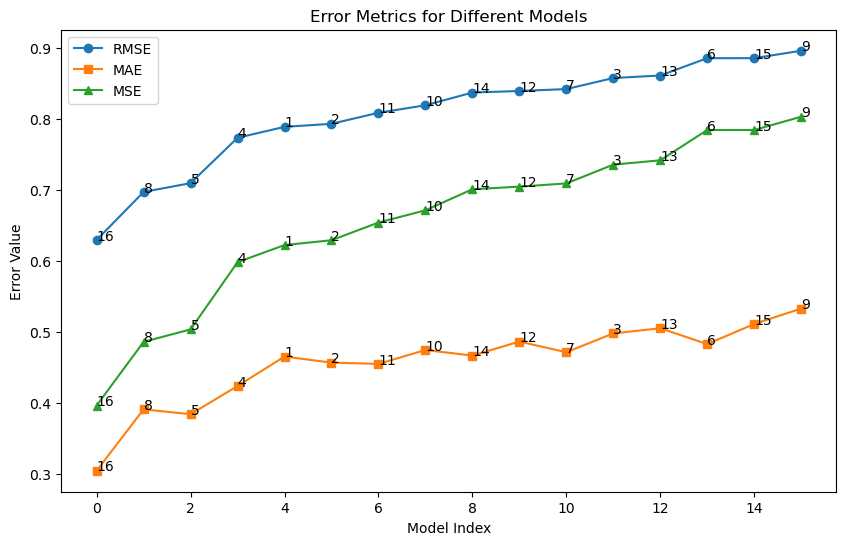

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

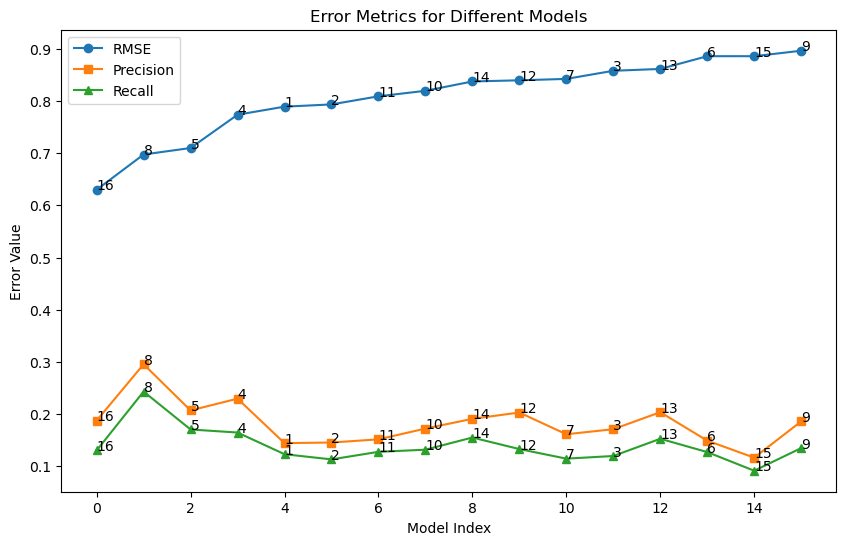

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

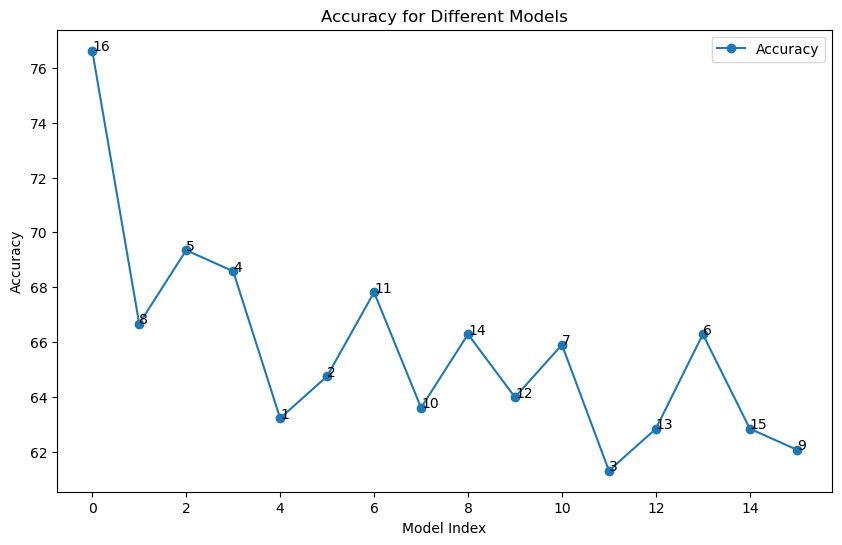

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Mercurey 'Clos les Bussières' 
2. Item ID: Théophile Brut Champagne
3. Item ID: Les Pierrelles Crozes-Hermitage
4. Item ID: Senorino de Baldios
5. Item ID: Le Grand Saumur
6. Item ID: Mendoza Pinot Grigio
7. Item ID: Beyerskloof Western Cape
8. Item ID: Beyerskloof Western Cape
9. Item ID: Cirus Madiran
10. Item ID: Cirus Madiran


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['20e0b694-84a5-4f11-9191-598f924c2947',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 'bc79b0e3-064d-4240-86de-e86499f577e8',
 '4ed273f7-1816-4f36-88c7-789125f011c7',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7',
 '2a62eecd-b0cd-4395-9f8c-7c912a208be2',
 '8d43f723-f1e6-42ae-9e08-484403d2f5a3',
 '2ae69fac-d491-412f-8164-ccaf59a230c2',
 '5ccd8030-047b-432c-a630-d784ab415756']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['Montepulciano 60',
 'Charlotte Rosé',
 '3／Chevalier de Lascomes',
 'Rimosso',
 'Théophile Brut Champagne',
 '19 crimes dark red',
 'Châteauneuf-du-Pape',
 'Ronco del Balbo Merlot',
 'Prosecco Elysian',
 'Corvina ']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 12 with sim 0.000000000000000
And the baseline estimate is: 3.348367731916712

#####

Note: If the baseline is 2.958133971291866 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,13016d41-00bd-411c-83f5-2b95691696b7,Bollicina,2.0,2.388694,"{'actual_k': 13, 'was_impossible': False}",23,9,0.388694
1,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.000000,"{'actual_k': 40, 'was_impossible': False}",46,46,0.000000
2,5ccd8030-047b-432c-a630-d784ab415756,Baden-Badener Merlot,4.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",77,1,0.965311
3,defee34b-7775-4889-b703-92b730d85e70,Cannubi Barolo,5.0,5.000000,"{'actual_k': 0, 'was_impossible': False}",5,1,0.000000
4,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Montefalco Rosso,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",56,1,0.000000
5,5ccd8030-047b-432c-a630-d784ab415756,Dettelbach Silvaner,3.0,3.000000,"{'actual_k': 22, 'was_impossible': False}",77,2,0.000000
6,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Prosecco Elysian,3.0,3.006745,"{'actual_k': 40, 'was_impossible': False}",105,2,0.006745
7,bc79b0e3-064d-4240-86de-e86499f577e8,2／17 @home #5,5.0,5.000000,"{'actual_k': 30, 'was_impossible': False}",38,9,0.000000
8,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Blancs,5.0,5.000000,"{'actual_k': 40, 'was_impossible': False}",105,13,0.000000
9,91cf68cc-9436-43e1-871d-33beef4d2337,Bardolino,2.0,2.000000,"{'actual_k': 19, 'was_impossible': False}",33,8,0.000000


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
260,bc79b0e3-064d-4240-86de-e86499f577e8,Dark Horse Shiraz,2.0,2.0,"{'actual_k': 1, 'was_impossible': False}",38,11,0.0
101,5ccd8030-047b-432c-a630-d784ab415756,Randersacker Spätburgunder Rosé,3.0,3.0,"{'actual_k': 22, 'was_impossible': False}",77,1,0.0
102,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Ribolla Gialla,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",56,2,0.0
105,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",131,123,0.0
107,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",131,123,0.0
109,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",131,123,0.0
110,014e4ed1-6f8b-4b25-917d-c167a2acca17,Bread & Butter Pinor Noir 2020,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",46,46,0.0
111,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,2.0,"{'actual_k': 24, 'was_impossible': False}",33,23,0.0
113,20e0b694-84a5-4f11-9191-598f924c2947,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 10, 'was_impossible': False}",14,123,0.0
114,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,2/5 大亂鬥 2,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",131,123,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
18,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",4,1,1.965311
87,bc79b0e3-064d-4240-86de-e86499f577e8,Veuve Ambal Methode Traditionelle Blanc de Blancs,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",38,0,1.965311
116,bc79b0e3-064d-4240-86de-e86499f577e8,La Rocca Soave Classico,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",38,1,1.965311
15,7c790e8b-b289-4190-a624-83db79de07af,Sierra Foothills Zinfandel,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",2,1,1.965311
187,b2dd097f-fad9-4daa-9218-d21128ec9ab9,Bricco delle Ciliegie Arneis Roero,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",1,1,1.965311
239,defee34b-7775-4889-b703-92b730d85e70,meeker,5.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",5,1,1.965311
237,23b6603a-928c-4e54-9c34-bdf3dcb45435,Bardolino,4.0,2.000000,"{'actual_k': 0, 'was_impossible': False}",1,8,2.000000
40,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.034689
94,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1.0,3.034689,"{'was_impossible': True, 'reason': 'User and/o...",105,1,2.034689
151,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,1.0,4.000000,"{'actual_k': 0, 'was_impossible': False}",46,1,3.000000
